In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from helpers import all_models_test, plot_predicted_vs_actual
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
from helpers import load_config
from colorectal_adenocarcinoma.data_preprocessor import preprocess_data

warnings.filterwarnings('ignore')

configs = load_config(os.path.join("configs", "configs.yaml"))


In [3]:
storage_dir = configs["STORAGE_DIR_STUDY2"]
mutations_df = pd.read_csv(storage_dir+"mutations_summary.csv")

pathological_df = pd.read_csv(storage_dir+"pathological_df.csv")

mutations_df.shape

(528, 3)

In [4]:
mutations_pcs = np.load(storage_dir+"mutations_first_5_pcs.npy")
mutations_emb_df = pd.DataFrame(mutations_pcs, columns=[f"MPC{i}" for i in range(1, 6)])
print(mutations_df.shape, mutations_emb_df.shape)

(528, 3) (528, 5)


In [5]:
mutations_emb_df["SAMPLE_ID"] = mutations_df["Tumor_Sample_Barcode"]

# pd.merge(pathological_df, mutations_emb_df, left_on="SAMPLE_ID")

In [6]:
pathological_df.columns

Index(['PATIENT_ID', 'AGE', 'SEX', 'PATH_M_STAGE', 'PATH_N_STAGE',
       'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS', 'PRIOR_DX',
       'RADIATION_THERAPY', 'WEIGHT', 'PFS_MONTHS', 'GENETIC_ANCESTRY_LABEL',
       'SAMPLE_ID', 'ONCOTREE_CODE', 'ANEUPLOIDY_SCORE', 'MSI_SCORE_MANTIS',
       'MSI_SENSOR_SCORE', 'TMB_NONSYNONYMOUS'],
      dtype='object')

In [7]:
df = pd.merge(pathological_df, mutations_emb_df, on="SAMPLE_ID", how="inner")
df.shape

(63, 23)

In [8]:
df = df.drop(["PATIENT_ID", "SAMPLE_ID"], axis=1)

df1 = df.drop(['MPC1', 'MPC2', 'MPC3', 'MPC4', 'MPC5', 'PFS_MONTHS'], axis=1)

df1 = preprocess_data(df1)

df2 = df[['MPC1', 'MPC2', 'MPC3', 'MPC4', 'MPC5']]

# X = df2.drop(["PFS_MONTHS"], axis=1)
# y = df.PFS_MONTHS
y = df['PFS_MONTHS']


Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


In [9]:
df1

,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ
0,40.0,1.0,2.50,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0
1,76.0,0.0,0.00,3.0,75.4,0,20.0,0.3252,0.47,3.800000,1,1,0,0,0,0
2,85.0,1.0,2.00,3.0,67.2,1,25.0,0.3500,0.37,4.066667,1,1,0,0,0,0
3,71.0,1.0,2.00,3.0,85.6,1,24.0,0.4577,0.02,7.666667,1,0,0,0,1,0
4,73.0,0.0,0.00,3.0,79.6,1,13.0,0.3456,0.13,8.666667,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,50.0,0.0,2.50,3.0,84.4,0,19.0,0.3494,0.57,3.333333,1,0,0,0,0,1
59,53.0,0.0,2.50,3.0,82.0,1,8.0,0.3555,0.50,1.733333,1,0,0,0,0,1
60,57.0,1.0,1.33,3.0,53.0,1,28.0,0.3401,0.11,3.166667,0,1,0,0,0,1
61,62.0,0.0,0.00,3.0,80.0,1,11.0,0.3388,0.35,2.766667,0,0,0,0,0,1


In [10]:
scaler = StandardScaler()
scaler.fit(df1)

StandardScaler()

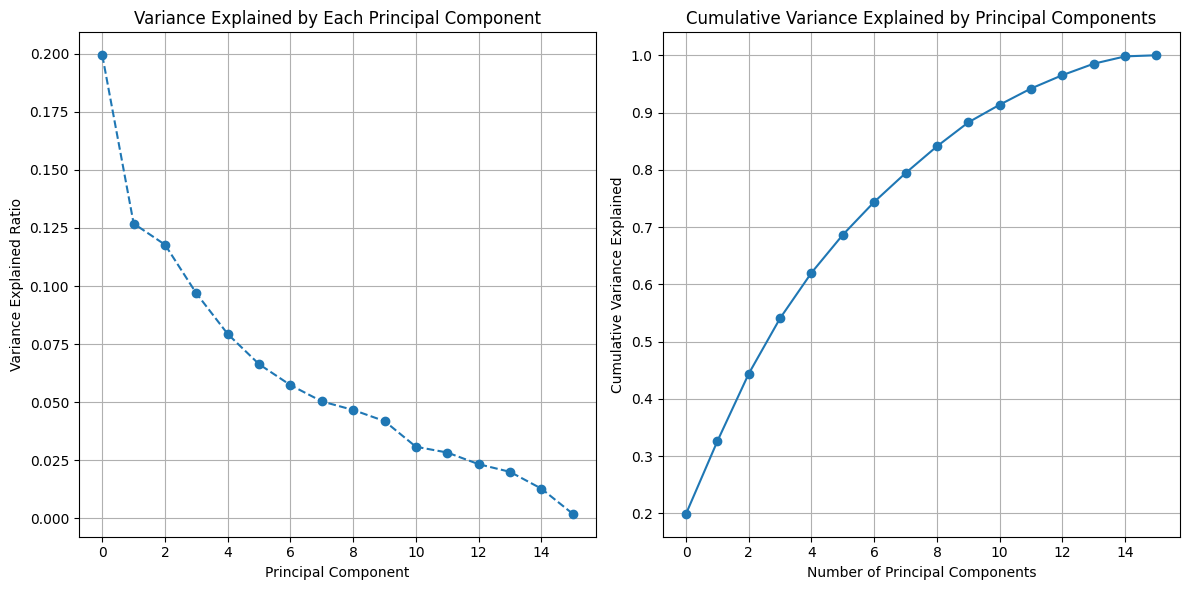

In [11]:
df1_std = scaler.transform(df1)

pca = PCA()

pca.fit(df1_std)

# Plot variance explained by each principal component
plt.figure(figsize=(12, 6))

# Plot explained variance ratio of each principal component
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)

# Plot cumulative variance explained
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)

plt.tight_layout()
plt.show()

Elbows at 2, 7, 11

In [12]:
X1 = pca.transform(df1_std)

n_components = 2
first_2_pcs = X1[:, :n_components]
print("Shape of first 2 principal components:", first_2_pcs.shape)

n_components = 7
first_4_pcs = X1[:, :n_components]
print("Shape of first 7 principal components:", first_4_pcs.shape)

n_components = 11
first_6_pcs = X1[:, :n_components]
print("Shape of first 11 principal components:", first_6_pcs.shape)

Shape of first 2 principal components: (63, 2)
Shape of first 7 principal components: (63, 7)
Shape of first 11 principal components: (63, 11)


## Combine pathological PCs with mutation PCs

In [13]:
m_5_pcs = df2.to_numpy()
m_5_pcs.shape

(63, 5)

In [14]:
X = np.concatenate((m_5_pcs, first_2_pcs), axis=1)
X.shape

(63, 7)

In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Regressor": SVR()
}

predictions = all_models_test(models, X, y)


Linear Regression - RMSE: 14.3463, R2: -20.5228%
Ridge Regression - RMSE: 14.3290, R2: -20.2329%
Lasso Regression - RMSE: 14.0310, R2: -15.2836%
Decision Tree Regression - RMSE: 20.3425, R2: -142.3247%
Random Forest Regression - RMSE: 14.8751, R2: -29.5717%
Gradient Boosting Regression - RMSE: 17.5409, R2: -80.1748%
Support Vector Regressor - RMSE: 13.6213, R2: -8.6492%


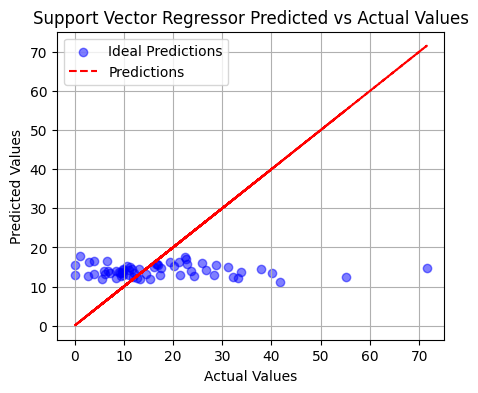

In [16]:
plot_predicted_vs_actual(predictions, "Support Vector Regressor")

Linear Regression - RMSE: 15.0899, R2: -33.3410%
Ridge Regression - RMSE: 15.0321, R2: -32.3206%
Lasso Regression - RMSE: 14.5152, R2: -23.3772%
Decision Tree Regression - RMSE: 19.4887, R2: -122.4099%
Random Forest Regression - RMSE: 14.6052, R2: -24.9113%
Gradient Boosting Regression - RMSE: 16.0775, R2: -51.3660%
Support Vector Regressor - RMSE: 13.6046, R2: -8.3830%


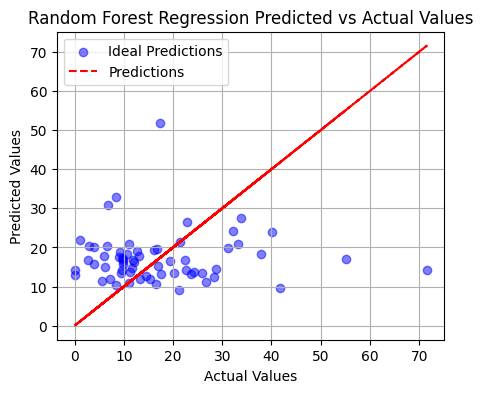

In [17]:
# trying 4 pcs
X = np.concatenate((m_5_pcs, first_4_pcs), axis=1)

predictions = all_models_test(models, X, y)

plot_predicted_vs_actual(predictions, "Random Forest Regression")

(-1.0, 14.0)

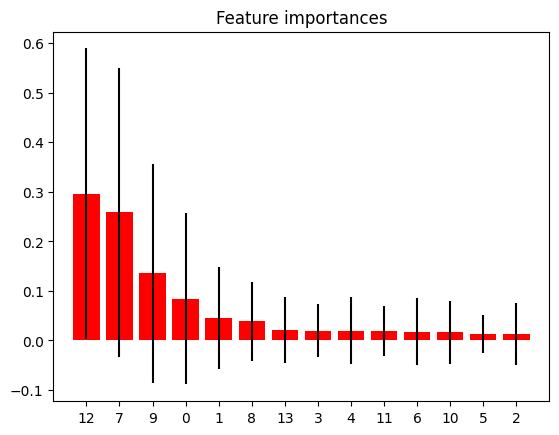

In [35]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to the data
rf_regressor.fit(X, y)

# Get feature importances
importances = rf_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
